- Get data from drive [link text](https://drive.google.com/file/d/19oZR2y1_ixa7g-jCT96ZoCmfPVAbmNAi/view?usp=sharing)

## Understanding Data

- importing Required Libraries

In [37]:
import pathlib
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import numpy as np
import tensorflow as tf
import os
from scipy import signal

import seaborn as sns

#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Normalization, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import layers
from tensorflow.keras import models

- Downloading fomr google drive and setting up Data

In [43]:
#!gdown --id 19oZR2y1_ixa7g-jCT96ZoCmfPVAbmNAi
#!unzip voice_data.zip -d /content/
#!rm -r voice_data.zip
import os

root_directory = os.getcwd()
root_directory = os.path.dirname(root_directory)
#data_directory = os.path.join(root_directory, "data")
data_directory = root_directory +"/data_jh/"

#print(root_directory)
#print(data_directory)


- Visualizing Raw Wavefiles Data

Text(0.5, 1.0, 'Audio: Green')

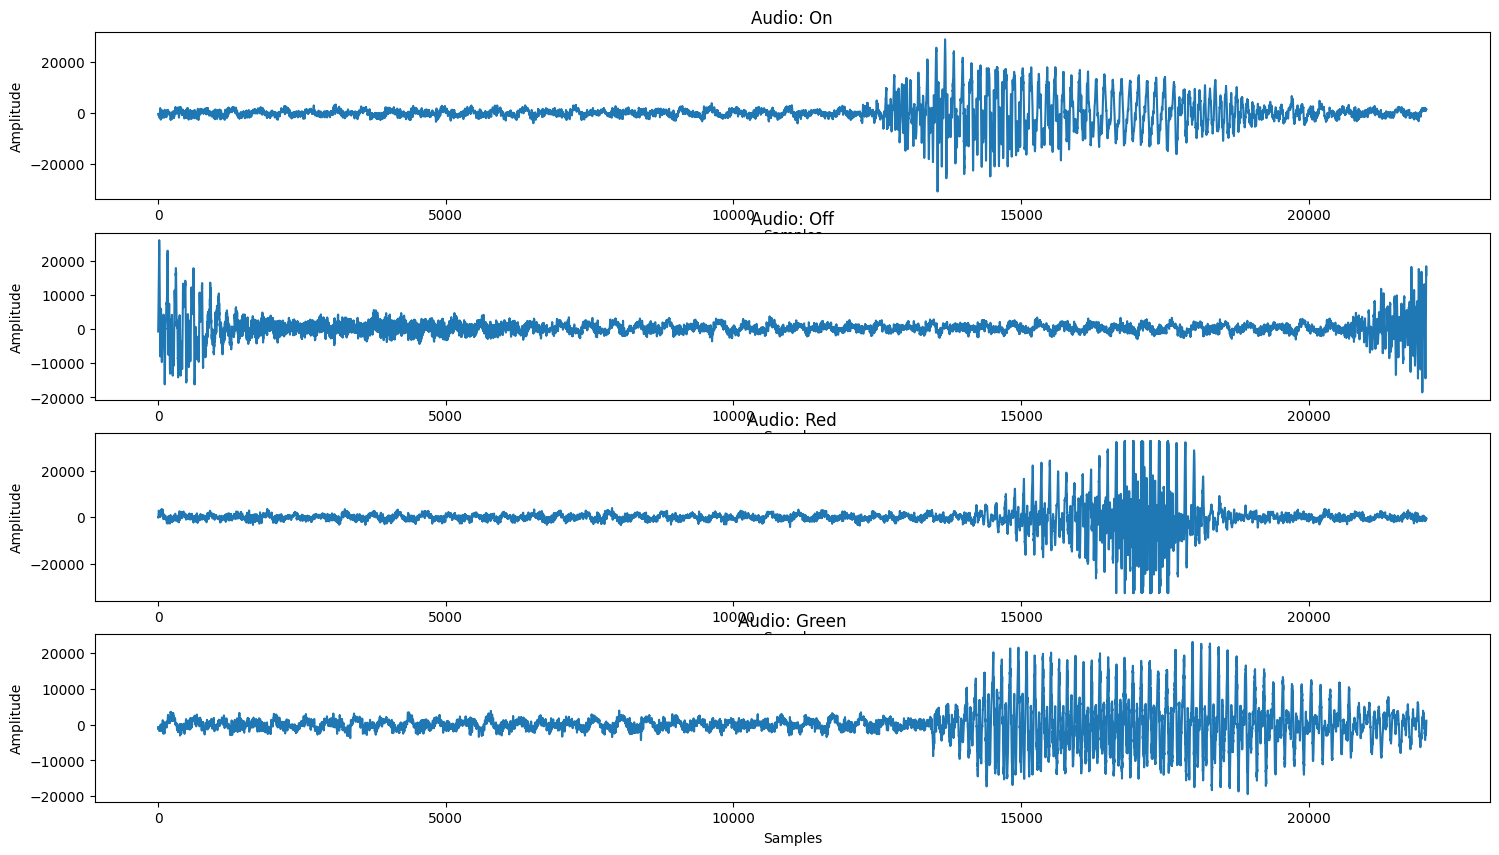

In [44]:
on_wav_file = read(data_directory+'on/on_00.wav')
off_wav_file = read(data_directory+'off/off_00.wav')
red_wav_file = read(data_directory+'red/red_00.wav')
green_wav_file = read(data_directory+'green/green_00.wav')

on_wav_file = on_wav_file[1]
off_wav_file = off_wav_file[1]
red_wav_file = red_wav_file[1]
green_wav_file = green_wav_file[1]


wavefile_plotter = plt.figure(figsize=(18,10)) 
on_plot     = wavefile_plotter.add_subplot(411)
off_plot    = wavefile_plotter.add_subplot(412)
red_plot    = wavefile_plotter.add_subplot(413)
green_plot  = wavefile_plotter.add_subplot(414)


on_plot.plot(on_wav_file )
on_plot.set_xlabel("Samples")
on_plot.set_ylabel('Amplitude')
on_plot.set_title('Audio: On')

off_plot.plot(off_wav_file )
off_plot.set_xlabel("Samples")
off_plot.set_ylabel('Amplitude')
off_plot.set_title('Audio: Off')

red_plot.plot(red_wav_file )
red_plot.set_xlabel("Samples")
red_plot.set_ylabel('Amplitude')
red_plot.set_title('Audio: Red')

green_plot.plot(green_wav_file )
green_plot.set_xlabel("Samples")
green_plot.set_ylabel('Amplitude')
green_plot.set_title('Audio: Green')



- Obtaining paths of wavefiles and labels from directories

In [45]:
data_dir = pathlib.Path(data_directory)
labels   = np.array( tf.io.gfile.listdir( str(data_dir) ) )
audio_files_with_path = tf.io.gfile.glob( str(data_dir) + '/*/*') 

audio_path_dataset = tf.random.shuffle(audio_files_with_path)

## Preprocessing Dataset into binary valued tensors

- Float tensor conversion test on single file

In [47]:
wav_file_path = data_directory+'on/on_00.wav'
label = tf.strings.split(wav_file_path , os.path.sep)
label = label[-2]

wav_audio = tf.io.read_file(wav_file_path)
audio_tensor,sr = tf.audio.decode_wav(wav_audio)
audio_tensor = tf.squeeze(audio_tensor , axis = -1)
audio_tensor.shape

TensorShape([22050])

- Function to convert wav files into labeled tensors 


In [48]:
def path_to_labeled_tensor(file_path):
  label = tf.strings.split(file_path , os.path.sep)
  label = label[-2]

  wav_audio = tf.io.read_file(file_path)
  audio_tensor,sr = tf.audio.decode_wav(wav_audio)
  audio_tensor = tf.squeeze(audio_tensor , axis = -1)
  return audio_tensor , label


data_tf_pipelines = tf.data.Dataset.from_tensor_slices(audio_path_dataset)
labled_wavform_dataset = data_tf_pipelines.map(path_to_labeled_tensor)


- Visualizing Waveforms with labels

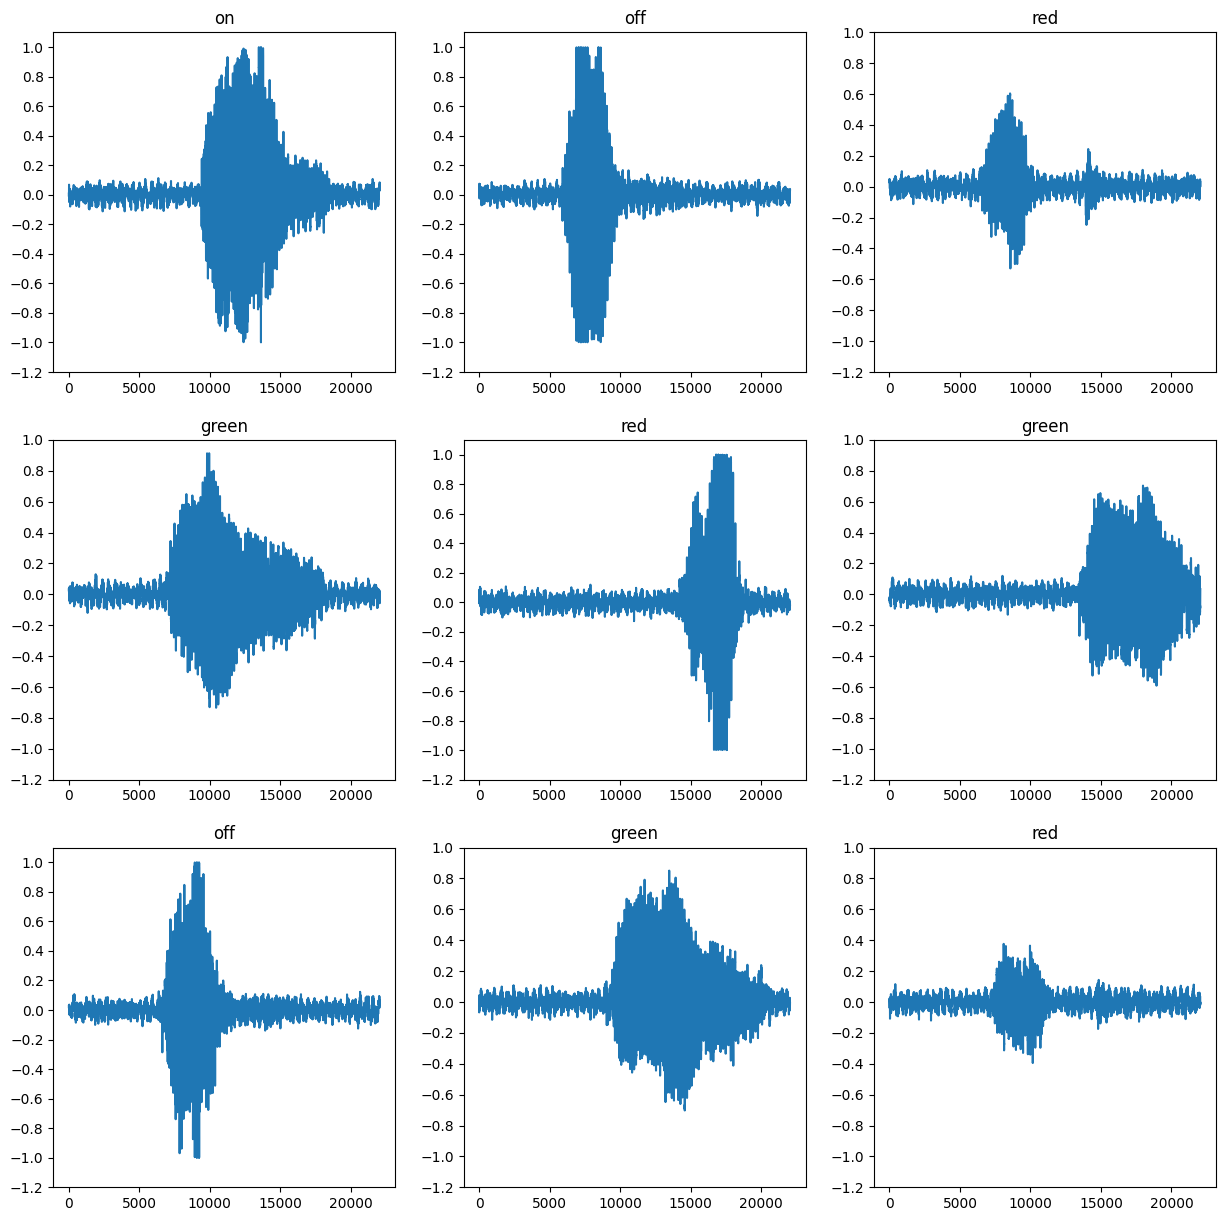

In [49]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for i, (audio, label) in enumerate(labled_wavform_dataset.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram Conversion

- Single file waveform tensor to spectrogram conversion test

In [50]:
for waveform , label in labled_wavform_dataset.take(20):
  f,t,spectrogram = signal.stft(waveform.numpy() , fs=22050, nperseg=255, noverlap = 124, nfft=256)
  spectrogram = tf.convert_to_tensor(np.abs(spectrogram))


spectrogram

<tf.Tensor: shape=(129, 170), dtype=float32, numpy=
array([[1.4673396e-02, 7.6550753e-03, 8.2884235e-03, ..., 3.0569119e-02,
        1.0364225e-02, 6.3346513e-04],
       [1.2561376e-02, 1.2470036e-02, 1.1000388e-02, ..., 2.1577595e-02,
        1.1423789e-02, 6.2730489e-04],
       [7.6863552e-03, 3.5844531e-03, 7.2021564e-03, ..., 8.7035010e-03,
        9.6553350e-03, 6.0960458e-04],
       ...,
       [2.9908174e-06, 1.4004377e-06, 2.0398541e-07, ..., 5.3821844e-07,
        3.2606404e-05, 8.3313989e-06],
       [2.5948161e-06, 1.1273759e-06, 4.6613533e-07, ..., 2.3104445e-07,
        3.2231230e-05, 8.3331861e-06],
       [1.7343078e-06, 1.1937286e-07, 4.7715014e-07, ..., 1.6382240e-08,
        3.2183289e-05, 8.3332961e-06]], dtype=float32)>

In [51]:
for waveform, label in labled_wavform_dataset.take(1):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  label = label.numpy().decode('utf-8')

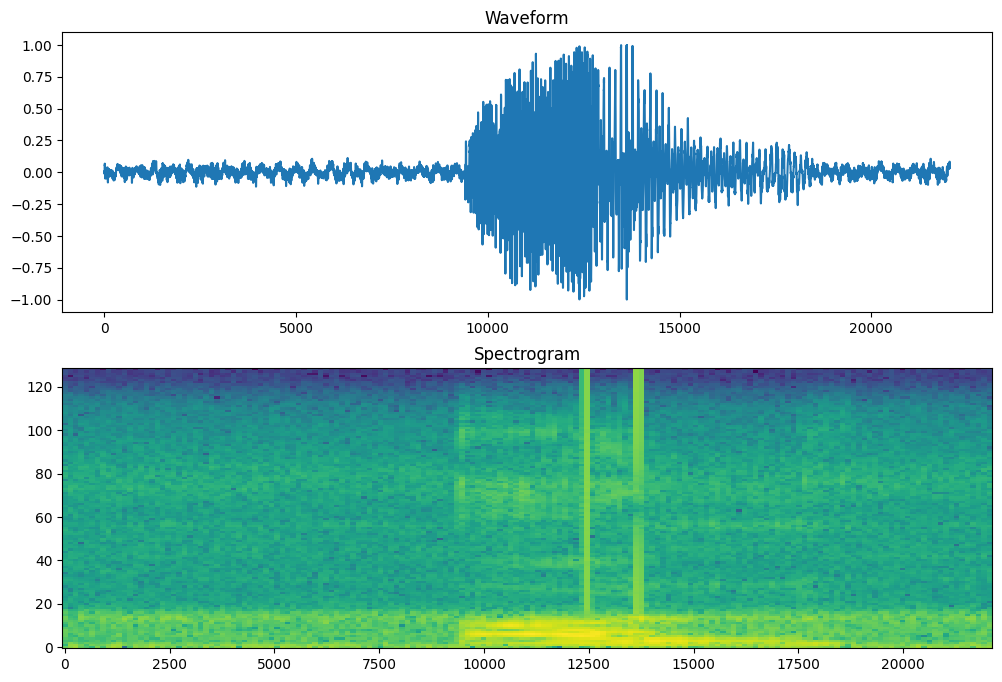

In [52]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

- Splitting Data into 
  - Validation
  - Testing
  - Training

In [53]:
training_dataset   =  audio_path_dataset[:140]
validation_dataset =  audio_path_dataset[140:170]
testing_dataset    =  audio_path_dataset[170:]

print("main Dataset Entries : ",len(audio_path_dataset))
print("Training Data Set entries :", len(training_dataset))
print("Validation Data Set entries :", len(validation_dataset))
print("Testing Data Set entries :", len(testing_dataset))

main Dataset Entries :  16
Training Data Set entries : 16
Validation Data Set entries : 0
Testing Data Set entries : 0


- Converting Raw Wav Path to Labled Spectrograms

In [54]:
def path_to_labeled_tensor(file_path):
  label = tf.strings.split(file_path , os.path.sep)
  label = label[-2]

  wav_audio = tf.io.read_file(file_path)
  audio_tensor,sr = tf.audio.decode_wav(wav_audio)
  audio_tensor = tf.squeeze(audio_tensor , axis = -1)
  return audio_tensor , label

def stft(waveform):
  f, t, spec = signal.stft(waveform.numpy(), fs=22050, nperseg=255, noverlap = 124, nfft=256)
  return tf.convert_to_tensor(np.abs(spec))

def wavforms_to_spectrograms(waveform,label):
  
  spectrogram = tf.py_function(func=stft, inp=[waveform], Tout=tf.float32)
  spectrogram.set_shape( (129,170))
  spectrogram = tf.expand_dims(spectrogram , axis =0 )
  label = tf.math.argmax(label==labels)
  return spectrogram , label
  
def raw_wavefile_path_to_Spectrogram(input_path_dataset):
  data_tf_pipelines          = tf.data.Dataset.from_tensor_slices(input_path_dataset)
  labled_wavform_dataset     = data_tf_pipelines.map(path_to_labeled_tensor)
  spectrogram_labled_dataset = labled_wavform_dataset.map(wavforms_to_spectrograms)
  return spectrogram_labled_dataset

training_ds   = raw_wavefile_path_to_Spectrogram(audio_path_dataset)
testing_ds    = raw_wavefile_path_to_Spectrogram(testing_dataset)
validation_ds = raw_wavefile_path_to_Spectrogram(validation_dataset) 


In [55]:
for waveform, label in training_ds.take(1):
  input_shape = waveform.shape

print("Input Shape ", input_shape)

Input Shape  (1, 129, 170)


In [56]:
training_ds

<_MapDataset element_spec=(TensorSpec(shape=(1, 129, 170), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

- Data into Batch

In [57]:
num_batch = 1
train_data_batch = training_ds.batch(num_batch)
valid_data_batch = validation_ds.batch(num_batch)

## Building and Training Model

### First Model 
- Batch size = 1
- Loss logits = False


In [58]:
norm_layer = Normalization()
norm_layer.adapt(train_data_batch.map(lambda x, _: x))

audio_led_model = models.Sequential()

audio_led_model.add(layers.Input(shape=input_shape))
#audio_led_model.add(preprocessing.Resizing(32, 32)) 
audio_led_model.add(Rescaling(32, 32)) 
audio_led_model.add(norm_layer)
audio_led_model.add(layers.Conv2D(32, 3, activation='relu'))
audio_led_model.add(layers.Conv2D(64, 3, activation='relu'))
audio_led_model.add(layers.MaxPooling2D())
audio_led_model.add(layers.Dropout(0.25))
audio_led_model.add(layers.Flatten())
audio_led_model.add(layers.Dense(128, activation='relu'))
audio_led_model.add(layers.Dropout(0.5))
audio_led_model.add(layers.Dense(len(labels)))
audio_led_model.summary()

ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 129, 170)`, `kernel shape=(3, 3, 170, 32)`, `dilation_rate=[1 1]`.

- Compile Modle

In [ ]:
audio_led_model.compile(
    optimizer =  tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'],
)


In [ ]:
history_1 = audio_led_model.fit(train_data_batch ,validation_data= valid_data_batch , epochs = 25 )

Epoch 1/25
200/200 [==============================] - 15s 7ms/step - loss: 9.4244 - accuracy: 0.2700 - val_loss: 10.3640 - val_accuracy: 0.3000
Epoch 2/25
200/200 [==============================] - 1s 6ms/step - loss: 9.5948 - accuracy: 0.2450 - val_loss: 10.3640 - val_accuracy: 0.3000
Epoch 3/25
200/200 [==============================] - 1s 6ms/step - loss: 10.2601 - accuracy: 0.2450 - val_loss: 11.2827 - val_accuracy: 0.3000
Epoch 4/25
200/200 [==============================] - 1s 6ms/step - loss: 11.4742 - accuracy: 0.2450 - val_loss: 11.2827 - val_accuracy: 0.3000
Epoch 5/25
200/200 [==============================] - 1s 6ms/step - loss: 11.1761 - accuracy: 0.2450 - val_loss: 11.2827 - val_accuracy: 0.3000
Epoch 6/25
200/200 [==============================] - 1s 6ms/step - loss: 11.6111 - accuracy: 0.2500 - val_loss: 11.2827 - val_accuracy: 0.3000
Epoch 7/25
200/200 [==============================] - 1s 6ms/step - loss: 8.4871 - accuracy: 0.2250 - val_loss: 1.3863 - val_accuracy: 0.

### Second Model
- Batch Size = 1
- Loss Logits = True

In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_data_batch.map(lambda x, _: x))

audio_led_model_2 = models.Sequential()

audio_led_model_2.add(layers.Input(shape=input_shape))
audio_led_model_2.add(preprocessing.Resizing(32, 32)) 
audio_led_model_2.add(norm_layer)
audio_led_model_2.add(layers.Conv2D(32, 3, activation='relu'))
audio_led_model_2.add(layers.Conv2D(64, 3, activation='relu'))
audio_led_model_2.add(layers.MaxPooling2D())
audio_led_model_2.add(layers.Dropout(0.25))
audio_led_model_2.add(layers.Flatten())
audio_led_model_2.add(layers.Dense(128, activation='relu'))
audio_led_model_2.add(layers.Dropout(0.5))
audio_led_model_2.add(layers.Dense(len(labels)))
audio_led_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 170)       0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 170)      341       
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        48992     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)       

In [ ]:
audio_led_model_2.compile(
    optimizer =  tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
)


In [ ]:
history_2 = audio_led_model_2.fit(train_data_batch ,validation_data= valid_data_batch , epochs = 25 )

Epoch 1/25
200/200 [==============================] - 2s 6ms/step - loss: 1.8202 - accuracy: 0.5150 - val_loss: 0.8656 - val_accuracy: 0.6333
Epoch 2/25
200/200 [==============================] - 1s 6ms/step - loss: 0.9643 - accuracy: 0.7700 - val_loss: 1.4524 - val_accuracy: 0.7667
Epoch 3/25
200/200 [==============================] - 1s 6ms/step - loss: 0.6492 - accuracy: 0.7850 - val_loss: 0.1274 - val_accuracy: 0.9667
Epoch 4/25
200/200 [==============================] - 1s 6ms/step - loss: 1.6136 - accuracy: 0.8200 - val_loss: 0.1404 - val_accuracy: 0.9667
Epoch 5/25
200/200 [==============================] - 2s 8ms/step - loss: 2.3292 - accuracy: 0.8050 - val_loss: 0.1726 - val_accuracy: 0.9333
Epoch 6/25
200/200 [==============================] - 1s 6ms/step - loss: 1.4073 - accuracy: 0.8850 - val_loss: 0.0668 - val_accuracy: 0.9667
Epoch 7/25
200/200 [==============================] - 1s 6ms/step - loss: 0.6315 - accuracy: 0.9150 - val_loss: 0.1813 - val_accuracy: 0.9333
Epoch 

### Third Model
- Batch Size = 2
- Loss Logits = True

In [ ]:
num_batch = 2
train_data_batch_1 = training_ds.batch(num_batch)
valid_data_batch_1 = validation_ds.batch(num_batch)

In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_data_batch_1.map(lambda x, _: x))

audio_led_model_3 = models.Sequential()

audio_led_model_3.add(layers.Input(shape=input_shape))
audio_led_model_3.add(preprocessing.Resizing(32, 32)) 
audio_led_model_3.add(norm_layer)
audio_led_model_3.add(layers.Conv2D(32, 3, activation='relu'))
audio_led_model_3.add(layers.Conv2D(64, 3, activation='relu'))
audio_led_model_3.add(layers.MaxPooling2D())
audio_led_model_3.add(layers.Dropout(0.25))
audio_led_model_3.add(layers.Flatten())
audio_led_model_3.add(layers.Dense(128, activation='relu'))
audio_led_model_3.add(layers.Dropout(0.5))
audio_led_model_3.add(layers.Dense(len(labels)))
audio_led_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 170)       0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 170)      341       
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        48992     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)       

In [ ]:
audio_led_model_3.compile(
    optimizer =  tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
)


In [ ]:
history_3 = audio_led_model_3.fit(train_data_batch_1 ,validation_data= valid_data_batch_1 , epochs = 25 )

Epoch 1/25
100/100 [==============================] - 2s 10ms/step - loss: 1.3220 - accuracy: 0.5950 - val_loss: 0.2889 - val_accuracy: 0.8667
Epoch 2/25
100/100 [==============================] - 1s 8ms/step - loss: 0.6944 - accuracy: 0.8450 - val_loss: 0.1640 - val_accuracy: 0.9333
Epoch 3/25
100/100 [==============================] - 1s 8ms/step - loss: 0.9942 - accuracy: 0.8050 - val_loss: 0.1764 - val_accuracy: 0.9333
Epoch 4/25
100/100 [==============================] - 1s 8ms/step - loss: 0.5595 - accuracy: 0.9000 - val_loss: 0.1170 - val_accuracy: 0.9667
Epoch 5/25
100/100 [==============================] - 1s 8ms/step - loss: 0.7145 - accuracy: 0.8950 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 6/25
100/100 [==============================] - 1s 8ms/step - loss: 0.3207 - accuracy: 0.9200 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 7/25
100/100 [==============================] - 1s 8ms/step - loss: 0.2657 - accuracy: 0.9400 - val_loss: 0.0881 - val_accuracy: 0.9667
Epoch

## Models Performance Comparison

- Loss Comparisons

Text(0.5, 1.0, 'Model:3 B:2 , Logits:True')

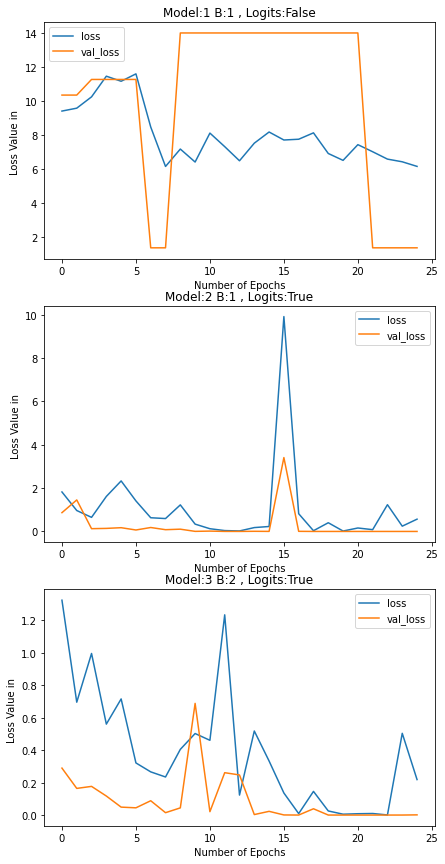

In [ ]:
wavefile_plotter = plt.figure(figsize=(7,20)) 
metrics_1  = wavefile_plotter.add_subplot(411)
metrics_2  = wavefile_plotter.add_subplot(412)
metrics_3  = wavefile_plotter.add_subplot(413)

metrics = history_1.history
metrics_1.plot(history_1.epoch, metrics['loss'], metrics['val_loss'])
metrics_1.legend(['loss', 'val_loss'])
metrics_1.set_xlabel("Number of Epochs")
metrics_1.set_ylabel('Loss Value in ')
metrics_1.set_title("Model:1 B:1 , Logits:False")

metrics = history_2.history
metrics_2.plot(history_2.epoch, metrics['loss'], metrics['val_loss'])
metrics_2.legend(['loss', 'val_loss'])
metrics_2.set_xlabel("Number of Epochs")
metrics_2.set_ylabel('Loss Value in ')
metrics_2.set_title("Model:2 B:1 , Logits:True")

metrics = history_3.history
metrics_3.plot(history_3.epoch, metrics['loss'], metrics['val_loss'])
metrics_3.legend(['loss', 'val_loss'])
metrics_3.set_xlabel("Number of Epochs")
metrics_3.set_ylabel('Loss Value in ')
metrics_3.set_title("Model:3 B:2 , Logits:True")

- Accuracy Comparisons

Text(0.5, 1.0, 'Model:3 B:2 , Logits:True')

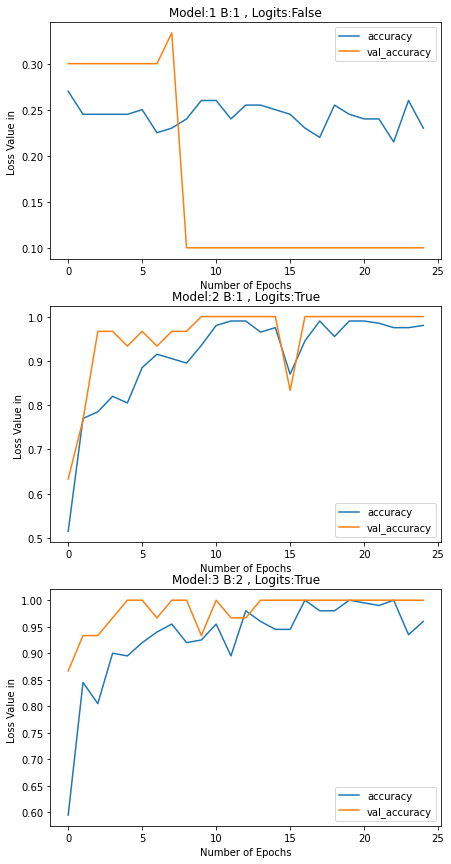

In [ ]:
wavefile_plotter = plt.figure(figsize=(7,20)) 
metrics_1  = wavefile_plotter.add_subplot(411)
metrics_2  = wavefile_plotter.add_subplot(412)
metrics_3  = wavefile_plotter.add_subplot(413)

metrics = history_1.history
metrics_1.plot(history_1.epoch, metrics['accuracy'], metrics['val_accuracy'])
metrics_1.legend(['accuracy', 'val_accuracy'])
metrics_1.set_xlabel("Number of Epochs")
metrics_1.set_ylabel('Loss Value in ')
metrics_1.set_title("Model:1 B:1 , Logits:False")

metrics = history_2.history
metrics_2.plot(history_2.epoch, metrics['accuracy'], metrics['val_accuracy'])
metrics_2.legend(['accuracy', 'val_accuracy'])
metrics_2.set_xlabel("Number of Epochs")
metrics_2.set_ylabel('Loss Value in ')
metrics_2.set_title("Model:2 B:1 , Logits:True")

metrics = history_3.history
metrics_3.plot(history_3.epoch, metrics['accuracy'], metrics['val_accuracy'])
metrics_3.legend(['accuracy', 'val_accuracy'])
metrics_3.set_xlabel("Number of Epochs")
metrics_3.set_ylabel('Loss Value in ')
metrics_3.set_title("Model:3 B:2 , Logits:True")

- Test Data Predictions


In [ ]:
test_specs  = []
testdata_labels = []
for spectrogram , label in testing_ds:
  test_specs.append(spectrogram.numpy())
  testdata_labels.append(label.numpy())


test_specs = np.array(test_specs)
testdata_labels = np. array(testdata_labels)

In [ ]:
model_prediction = audio_led_model_3.predict(test_specs)

print(" All Labels :" , labels)
print("Model Predictions :", model_prediction[10])
print("Actual Label :",testdata_labels[10])
print("Max Value of prediction :" , np.argmax(model_prediction[10]))

 All Labels : ['off' 'on' 'green' 'red']
Model Predictions : [  0.2282763  28.68038    -5.7723317 -14.020389 ]
Actual Label : 1
Max Value of prediction : 1


In [ ]:
model_prediction_labels = np.argmax(audio_led_model_3.predict(test_specs) , axis =1)
model_prediction_labels

array([3, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 3, 0, 3, 0, 1, 2, 3, 2, 3,
       3, 3, 0, 1, 3, 0, 1, 2])

- Confusion matrix

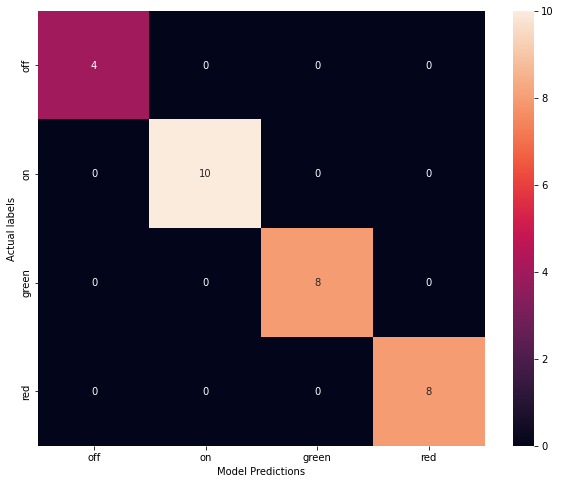

In [ ]:
confusion_matrix = tf.math.confusion_matrix(testdata_labels,model_prediction_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,yticklabels=labels,xticklabels=labels,annot=True, fmt='g')
plt.xlabel('Model Predictions')
plt.ylabel('Actual labels')
plt.show()

- Saving Model

In [ ]:
audio_led_model_3.save("/content/audio_led_model_3.h5")

## TensorFlow Lite Coversion and Comparisons

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(audio_led_model_3)
converter.optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1ihrbvi4/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ihrbvi4/assets


In [ ]:
open("audio_led_model_3.tflite","wb").write(tflite_model)
print("Main Model Size :" , round((os.path.getsize("/content/audio_led_model_3.h5"))/(1024*1024) ,3 ) , "MB")
print("Lite Model Size :" , round((os.path.getsize("/content/audio_led_model_3.tflite"))/(1024*1024),3 ), "MB"  )

Main Model Size : 19.204 MB
Lite Model Size : 6.39 MB


- Testing TFLite Model

In [ ]:
interpreter = tf.lite.Interpreter('/content/audio_led_model_3.tflite')

input_details   = interpreter.get_input_details()
output_details = interpreter.get_output_details()


print(input_details)

print("-"*10)
print(output_details)
print("-"*10)
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

[{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1,   1, 129, 170], dtype=int32), 'shape_signature': array([ -1,   1, 129, 170], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
----------
[{'name': 'StatefulPartitionedCall:0', 'index': 21, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
----------
Input Shape: [  1   1 129 170]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


 - Inferencing

In [ ]:
test_file = '/content/data/red/red_1.wav'

test_single_file = raw_wavefile_path_to_Spectrogram([str(test_file)])

for spectrogram , label in test_single_file.batch(1):
  interpreter.allocate_tensors()
  interpreter.set_tensor(input_details[0]['index'] , spectrogram)
  interpreter.invoke()

  tflite_prediction_result = interpreter.get_tensor(output_details[0]['index'])
  print("Lite Model Predictions :",tflite_prediction_result, "\n" ) #  labels[np.argmax(tflite_prediction_result)] 

Lite Model Predictions : [[-10.525799  11.268749 -18.565294  77.58388 ]] 



In [ ]:
labels

array(['off', 'on', 'green', 'red'], dtype='<U5')